# Modelling traffic using social media

## 0.0 Imports

In [1]:
# imports used in Selenium
from selenium import webdriver
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException, StaleElementReferenceException
from selenium.webdriver.common.keys import Keys
from time import sleep

# general python imports i.e. working with dataframes and basic maths
import pandas as pd
import numpy as np

# used to get most common words
from sklearn.feature_extraction.text import CountVectorizer

import math


from gensim.models.word2vec import Word2Vec

import spacy
nlp = spacy.load('en_core_web_sm')


import sys,getopt,datetime,codecs

# Grabbing Tweets
from got3.manager import TweetCriteria
from got3.manager import TweetManager
import got3

# Named Entity Recognition
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

# sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Stop words
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Modelling imports
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

# Graph imports
import matplotlib.pyplot as plt
import seaborn as sns

import itertools

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\ProgramData\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## 1.0 Functions

In [2]:
# File naming function
def filename_maker(title,type_of_output):
    time = datetime.datetime.now().strftime("%y%m%d_%Hh%Mm")
    filename = time + "_" + type_of_output + "_" + title
    return filename

### 1.1 Tweet data functions

In [3]:
# Function to grab tweets containing 'ExtinctionRebellion'
def ER_tweets():
    tweets_master_ls = []
    
    print('Setting tweet criteria')
    tweetCriteria = got3.manager.TweetCriteria().setQuerySearch('ExtinctionRebellion').setSince('2019-01-01')
    print('Getting tweets')
    tweets = got3.manager.TweetManager.getTweets(tweetCriteria)


    tweet_counter = 0
    for tweet in tweets:
        #try:
        account_tweet_dict = {'tweet_text' : tweet.text,
                     'user' : tweet.username,
                     'date' : tweet.date,
                     'retweets' : tweet.retweets,
                             'geo':tweet.geo,
                             'favorites':tweet.favorites}

        tweets_master_ls.append(account_tweet_dict)
        tweet_counter += 1

        if tweet_counter % 10 == 0:
            print(f"{tweet_counter} tweets grabbed")

        #except:
         #   print('An exception has occurred type 1')

    tweets_df = pd.DataFrame(tweets_master_ls)
    
    # Set output file name
    csv_type_of_output = 'Tweets_RAW'
    csv_filename = filename_maker('ER', csv_type_of_output)
    
    #Outputting to csv
    print('Outputting raw scrape results, filename: ' + csv_filename + '.csv')
    tweets_df.to_csv(csv_filename + '.csv')
    
    return tweets_df

In [4]:
# Function to grab tweets from an account
def account_tweets_grabber(handle):
    
    account_tweets_lst = []
    
    tweetCriteria = got3.manager.TweetCriteria().setUsername(handle.replace('@','')).setSince('2019-01-01')
    tweets = got3.manager.TweetManager.getTweets(tweetCriteria)

    tweet_counter = 0
    for tweet in tweets:
        try:
            account_tweet_dict = {'tweet_text' : tweet.text,
                         'user' : handle,
                         'date' : tweet.date,
                         'retweets' : tweet.retweets}

            account_tweets_lst.append(account_tweet_dict)
            tweet_counter += 1

            if tweet_counter % 10 == 0:
                print(f"{tweet_counter} tweets grabbed from account: {handle}")
        except:
            print('An exception has occurred')
            
    account_tweets_df = pd.DataFrame(account_tweets_lst)
            
    return account_tweets_df

### 1.2 Text processing functions

In [5]:
def named_entity(x):

    doc = nlp(x)

    return [(X.text, X.label_) for X in doc.ents]

In [6]:
def sentiment_analyser(text):
    sentiment_scores = analyzer.polarity_scores(str(text))
    
    return sentiment_scores

### 1.3 Text cleaning

In [7]:
# function to find and replace words in a string using a dictionary
def find_replace(string, dictionary):
    
    replacement_list = []
    
    # is the item in the dict?
    for item in string.split():
        # iterate by keys
        if item in dictionary.keys():
            # look up and replace
            replacement_list.append(item)
            #string.replace(item, dictionary[item])
            
    for word in replacement_list:
        
        string = string.replace(word, dictionary[word])
    # return updated string
    return string

In [8]:
# Dictionary of apostrophe conversions to find and replace on
appos = {"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not"}

In [9]:
def tweet_text_cleaner(text):
    clean_text = str(text).lower().replace(',', ' ').replace('’',"'")
    
    clean_text = find_replace(str(clean_text), appos)
    
    return clean_text

### 1.4 Specific location tagging

In [10]:
def marble_arch_detector(text):
    if 'marblearch' in text.replace(' ','').lower():
        marble_arch_present = 1
    else:
        marble_arch_present = 0
        
    return marble_arch_present

def waterloo_detector(text):
    if 'waterloo' in text.replace(' ','').lower():
        waterloo_present = 1
    else:
        waterloo_present = 0
        
    return waterloo_present

def oxford_circus_detector(text):
    if 'oxfordcircus' in text.replace(' ','').lower():
        oxford_circus_present = 1
    else:
        oxford_circus_present = 0
        
    return oxford_circus_present

def regent_street_detector(text):
    if 'regentstreet' in text.replace(' ','').lower():
        regent_street_present = 1
    else:
        regent_street_present = 0
        
    return regent_street_present

def parliament_square_detector(text):
    if 'parliamentsquare' in text.replace(' ','').lower():
        parliament_square_present = 1
    else:
        parliament_square_present = 0
        
    return parliament_square_present

### 1.5 Traffic flag

In [11]:
def traffic_flagger(row):
    traffic_flag = 0
    if row['marble_arch'] == 1:
        traffic_flag = 1
    elif row['waterloo'] == 1:
        traffic_flag = 1    
    elif row['oxford_circus'] == 1:
        traffic_flag = 1
    elif row['regent_street'] == 1:
        traffic_flag = 1
    elif row['parliament_square'] == 1:
        traffic_flag = 1
        
    return traffic_flag

### 1.6 Processing datetime

In [12]:
def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +datetime.timedelta(hours=t.minute//30))

### 1.7 Model Evaluation

In [13]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## 2.0 Input data

### 2.1 Get Extinction Rebellion tweets

In [ ]:
ER_tweets = ER_tweets()

### 2.2 Get TFL Traffic News tweets

In [ ]:
handle = '@TfLTrafficNews'

TfLTrafficNews_tweets = account_tweets_grabber(handle)

In [ ]:
TfLTrafficNews_tweets.to_csv('TfLTrafficNews_tweets_20190617.csv')

## 3.0 Process data

### 3.1 Named entity

In [ ]:
ER_tweets['named_entity'] = ER_tweets['tweet_text'].map(lambda x: named_entity(x))
print('ER_tweets named entity done')
TfLTrafficNews_tweets['named_entity'] = TfLTrafficNews_tweets['tweet_text'].map(lambda x: named_entity(x))
print('TfLTrafficNews_tweets named entity done')

### 3.2 Clean tweet data

In [ ]:
ER_tweets['tweet_text_clean'] = ER_tweets['tweet_text'].map(lambda x: tweet_text_cleaner(x))
TfLTrafficNews_tweets['tweet_text_clean'] = TfLTrafficNews_tweets['tweet_text'].map(lambda x: tweet_text_cleaner(x))

### 3.3 Flag for known protest locations

In [ ]:
# Flag locations in extinction rebellion tweets
ER_tweets['marble_arch_flag'] = ER_tweets['tweet_text_clean'].map(lambda x: marble_arch_detector(x))
ER_tweets['waterloo_flag'] = ER_tweets['tweet_text_clean'].map(lambda x: waterloo_detector(x))
ER_tweets['oxford_circus_flag'] = ER_tweets['tweet_text_clean'].map(lambda x: oxford_circus_detector(x))
ER_tweets['regent_street_flag'] = ER_tweets['tweet_text_clean'].map(lambda x: regent_street_detector(x))
ER_tweets['parliament_square_flag'] = ER_tweets['tweet_text_clean'].map(lambda x: parliament_square_detector(x))

In [ ]:
# Flag locations in TFL traffic tweets
TfLTrafficNews_tweets['marble_arch'] = TfLTrafficNews_tweets['tweet_text_clean'].map(lambda x: marble_arch_detector(x))
TfLTrafficNews_tweets['waterloo'] = TfLTrafficNews_tweets['tweet_text_clean'].map(lambda x: waterloo_detector(x))
TfLTrafficNews_tweets['oxford_circus'] = TfLTrafficNews_tweets['tweet_text_clean'].map(lambda x: oxford_circus_detector(x))
TfLTrafficNews_tweets['regent_street'] = TfLTrafficNews_tweets['tweet_text_clean'].map(lambda x: regent_street_detector(x))
TfLTrafficNews_tweets['parliament_square'] = TfLTrafficNews_tweets['tweet_text_clean'].map(lambda x: parliament_square_detector(x))

#### 3.31 Add flag for any traffic

In [ ]:
TfLTrafficNews_tweets['traffic'] = TfLTrafficNews_tweets.apply(lambda x: traffic_flagger(x), axis=1)

#### 3.32 Check values

In [ ]:
TfLTrafficNews_tweets['traffic'].value_counts()

### 3.5 Add sentiment to protest tweets

In [ ]:
ER_tweets['sentiment_scores'] = ER_tweets['tweet_text'].map(lambda x: sentiment_analyser(str(x)))
ER_tweets['overall_sentiment'] = ER_tweets['sentiment_scores'].map(lambda x: x['compound'])

### 3.6 Merge traffic data to protest Tweet data

In [ ]:
ER_tweets.head(3)

In [ ]:
# Round datetime to match files together
ER_tweets['date_mins'] = ER_tweets['date'].values.astype('<M8[m]')
TfLTrafficNews_tweets['date_mins'] = TfLTrafficNews_tweets['date'].values.astype('<M8[m]')

ER_tweets['date_hour'] = ER_tweets['date'].map(lambda x: hour_rounder(x))
TfLTrafficNews_tweets['date_hour'] = TfLTrafficNews_tweets['date'].map(lambda x: hour_rounder(x))

In [ ]:
# Reduce to just key column and modelling column
TfLTrafficNews_for_model = TfLTrafficNews_tweets[['date_hour','traffic']]

In [ ]:
# Only keep rows that indicate traffic and dedupe to avoid duplication on the merge
TfLTrafficNews_for_model = TfLTrafficNews_for_model[TfLTrafficNews_for_model['traffic'] == 1]

TfLTrafficNews_for_model.drop_duplicates(inplace=True)

In [ ]:
# merge to create DF for modelling
modelling_df = ER_tweets.merge(TfLTrafficNews_for_model, how='left', on='date_hour', indicator=True)

In [ ]:
modelling_df['traffic'].fillna(0, inplace=True)

In [ ]:
modelling_df.head(3)

In [ ]:
# Check match rate
modelling_df['_merge'].value_counts()

In [ ]:
# Drop unused columns
modelling_df.drop(columns=['geo','user','named_entity','tweet_text','sentiment_scores'], inplace=True)

In [ ]:
modelling_df.columns

In [ ]:
modelling_df.shape

### 3.7 Check all values in tweet text are strings

In [ ]:
modelling_df['type_string'] = modelling_df['tweet_text_clean'].map(lambda x: True if type(x) == str else False)
modelling_df['type_string'].value_counts()

### 3.8 Backup processed files

In [ ]:
ER_tweets.to_csv('ER_tweets_20190618.csv')
TfLTrafficNews_tweets.to_csv('TfLTrafficNews_tweets_20190618.csv')
modelling_df.to_csv('modelling_df_20190618.csv')

## 4.0 Modelling

In [14]:
# Load data
modelling_df = pd.read_csv('modelling_df_20190618.csv')
modelling_df = modelling_df.drop('Unnamed: 0', axis=1)
modelling_df.head()

,date,favorites,retweets,tweet_text_clean,marble_arch,waterloo,oxford_circus,regent_street,parliament_square,overall_sentiment,date_mins,date_hour,marble_arch_flag,waterloo_flag,oxford_circus_flag,regent_street_flag,parliament_square_flag,traffic,_merge,type_string
0,2019-06-16 16:25:50,0,0,a plan by climate protesters to shut down heat...,0,0,0,0,0,-0.3400,2019-06-16 16:25:00,2019-06-16 16:00:00,0,0,0,0,0,0.0,left_only,True
1,2019-06-16 16:25:01,0,0,# breakingnews kenneth clarke: ‘if there is no...,0,0,0,0,0,-0.2960,2019-06-16 16:25:00,2019-06-16 16:00:00,0,0,0,0,0,0.0,left_only,True
2,2019-06-16 16:24:03,0,0,# extinctionrebellion quite happy to risk peop...,0,0,0,0,0,0.3878,2019-06-16 16:24:00,2019-06-16 16:00:00,0,0,0,0,0,0.0,left_only,True
3,2019-06-16 16:23:32,0,0,extinction rebellion delays drone protest at b...,0,0,0,0,0,-0.3612,2019-06-16 16:23:00,2019-06-16 16:00:00,0,0,0,0,0,0.0,left_only,True
4,2019-06-16 16:22:02,1,0,heathrow/extinction rebellion: the plan to clo...,0,0,0,0,0,0.3182,2019-06-16 16:22:00,2019-06-16 16:00:00,0,0,0,0,0,0.0,left_only,True


In [15]:
modelling_df['traffic'].value_counts()

0.0    17228
1.0     1690
Name: traffic, dtype: int64

### 4.1 Address class imbalance

In [16]:
traffic_df = modelling_df.loc[modelling_df.traffic == 1]

non_traffic = modelling_df.loc[modelling_df.traffic == 0]

modelling_df = pd.concat([traffic_df, non_traffic.sample(1600)]).sort_index()

print(modelling_df.shape)
modelling_df.head()

(3290, 20)


,date,favorites,retweets,tweet_text_clean,marble_arch,waterloo,oxford_circus,regent_street,parliament_square,overall_sentiment,date_mins,date_hour,marble_arch_flag,waterloo_flag,oxford_circus_flag,regent_street_flag,parliament_square_flag,traffic,_merge,type_string
6,2019-06-16 16:20:51,0,0,the united states needs something like the uk'...,0,0,0,0,0,0.5859,2019-06-16 16:20:00,2019-06-16 16:00:00,0,0,0,0,0,0.0,left_only,True
18,2019-06-16 16:07:17,0,0,grouplove - welcome to your life [official vid...,0,0,0,0,0,0.2422,2019-06-16 16:07:00,2019-06-16 16:00:00,0,0,0,0,0,0.0,left_only,True
19,2019-06-16 16:05:33,0,1,extinction rebellion postpones heathrow flight...,0,0,0,0,0,-0.2382,2019-06-16 16:05:00,2019-06-16 16:00:00,0,0,0,0,0,0.0,left_only,True
26,2019-06-16 15:49:37,6,2,a small crew of brave rebels were in # fortgre...,0,0,0,0,0,0.7579,2019-06-16 15:49:00,2019-06-16 16:00:00,0,0,0,0,0,0.0,left_only,True
30,2019-06-16 15:47:00,0,0,media scepticism about theresa may's net-zero ...,0,0,0,0,0,-0.0516,2019-06-16 15:47:00,2019-06-16 16:00:00,0,0,0,0,0,0.0,left_only,True


In [17]:
modelling_df.isna().sum()

date                      0
favorites                 0
retweets                  0
tweet_text_clean          3
marble_arch               0
waterloo                  0
oxford_circus             0
regent_street             0
parliament_square         0
overall_sentiment         0
date_mins                 0
date_hour                 0
marble_arch_flag          0
waterloo_flag             0
oxford_circus_flag        0
regent_street_flag        0
parliament_square_flag    0
traffic                   0
_merge                    0
type_string               0
dtype: int64

In [18]:
modelling_df = modelling_df.dropna()

### 4.1 TFID

In [19]:
# Set stopwords
additional_stopwords = ['https','http']
add_stop_words = ENGLISH_STOP_WORDS.union(additional_stopwords)

In [20]:
vect = TfidfVectorizer(max_features=2500, ngram_range=(1,4), stop_words=add_stop_words)

vect.fit(modelling_df['tweet_text_clean'])

text_X = vect.transform(modelling_df['tweet_text_clean']).toarray()

In [21]:
modelling_df.head(2)

,date,favorites,retweets,tweet_text_clean,marble_arch,waterloo,oxford_circus,regent_street,parliament_square,overall_sentiment,date_mins,date_hour,marble_arch_flag,waterloo_flag,oxford_circus_flag,regent_street_flag,parliament_square_flag,traffic,_merge,type_string
6,2019-06-16 16:20:51,0,0,the united states needs something like the uk'...,0,0,0,0,0,0.5859,2019-06-16 16:20:00,2019-06-16 16:00:00,0,0,0,0,0,0.0,left_only,True
18,2019-06-16 16:07:17,0,0,grouplove - welcome to your life [official vid...,0,0,0,0,0,0.2422,2019-06-16 16:07:00,2019-06-16 16:00:00,0,0,0,0,0,0.0,left_only,True


In [22]:
modelling_df.columns

Index(['date', 'favorites', 'retweets', 'tweet_text_clean', 'marble_arch',
       'waterloo', 'oxford_circus', 'regent_street', 'parliament_square',
       'overall_sentiment', 'date_mins', 'date_hour', 'marble_arch_flag',
       'waterloo_flag', 'oxford_circus_flag', 'regent_street_flag',
       'parliament_square_flag', 'traffic', '_merge', 'type_string'],
      dtype='object')

In [23]:
feature_cols_list = list(modelling_df[['favorites', 'retweets','marble_arch','waterloo',
                             'oxford_circus','regent_street','parliament_square',
                             'overall_sentiment']].columns)

In [24]:
non_text_features = modelling_df[feature_cols_list].as_matrix()

In [25]:
%%time
x = np.hstack((text_X, non_text_features))

Wall time: 43.6 ms


### 4.2 Logistic Regression

In [26]:
%%time
# Run gridsearch
lr = LogisticRegression()
y = modelling_df['traffic']

params = {'C' : [0.01, 0.1, 0.9, 1.1],
         'penalty' : ['l1', 'l2']}

gs_lr = GridSearchCV(lr, param_grid=params, verbose=1, n_jobs=-1)
gs_lr.fit(x, y)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   29.6s finished


Wall time: 30.2 s


In [27]:
gs_lr.best_score_

0.5214481289930027

In [28]:
gs_lr.best_params_

{'C': 1.1, 'penalty': 'l1'}

##### Seemed to work better without penalty function

In [29]:
%%time
# Model
lr = LogisticRegression(C = 8)

y = modelling_df['traffic']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

lr.fit(x_train, y_train)

pred = lr.predict(x_test)

score = lr.score(x_test, y_test)
print(score)

(2300, 2508) (987, 2508)
(2300,) (987,)
0.5724417426545086
Wall time: 188 ms


In [30]:
# Look into model coefficients
coeffs_df = pd.DataFrame({'Coefficients' : lr.coef_[0], 'Features' : vect.get_feature_names() + feature_cols_list}).sort_values('Coefficients', ascending = False)
coeffs_df.head(20)

,Coefficients,Features
1292,5.242190,ist
1361,4.261164,latest
1670,3.838652,point
1963,3.721188,runway
1694,3.379213,pour
1471,3.324295,met
107,3.160162,40
1288,3.144652,involved
1398,3.137073,local
2083,3.120922,stance


In [31]:
# Quick look at the tail
coeffs_df.tail(20)

,Coefficients,Features
1328,-2.795624,justice
360,-2.805275,chain
2377,-2.818147,weeks
2499,-2.822404,zur
1073,-2.835090,future climateemergency
1587,-2.865111,open
268,-2.879019,biodiversity
933,-2.891686,extinctionrebel
1890,-2.895954,record
1068,-2.955907,fucking


#### 4.21 Evaluate model

In [32]:
# create a new df for test scores
model_output = modelling_df.loc[y_test.index]

model_output['prediction'] = pred

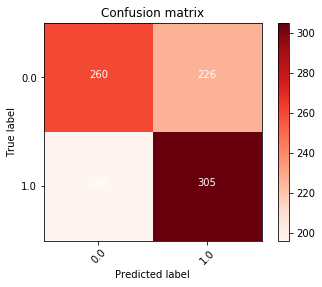

In [33]:
# Take a look at confusion matrix
conmat = metrics.confusion_matrix(model_output['traffic'].values, model_output['prediction'].values)
classes = np.array([ 0.,  1.])
plot_confusion_matrix(conmat, classes)

In [34]:
print(classification_report(model_output['traffic'], model_output['prediction']))

             precision    recall  f1-score   support

        0.0       0.57      0.53      0.55       486
        1.0       0.57      0.61      0.59       501

avg / total       0.57      0.57      0.57       987

